# 자전거 대여 개수 예측모델 만들기

In [121]:
# 데이터 불러오기
import pandas as pd
train_df = pd.read_csv("./datasets/train.csv")
test_df = pd.read_csv("./datasets/test.csv")

## 데이터불러오기

In [122]:
# 데이터 탐색하기
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


데이터에 결측치가 없음, Dtype이 object인 형태 전처리

In [123]:
# 필요없는 칼럼 없애기
train_df = train_df.drop(columns = ['casual','registered'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


casual(미등록자), registered(등록자) 두 개의 합은 count값이라는 걸 알 수 있으므로 삭제

## 데이터 EDA
1. 상관관계분석 시작
2. 데이터가 타겟데이터와 어떤 상관이 있는지 파악


In [124]:
# 상관관계분석
corr = train_df.drop(columns = 'datetime').corr()
corr

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


In [125]:
# 굴림체 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Gulim'
plt.rcParams['axes.unicode_minus'] = False

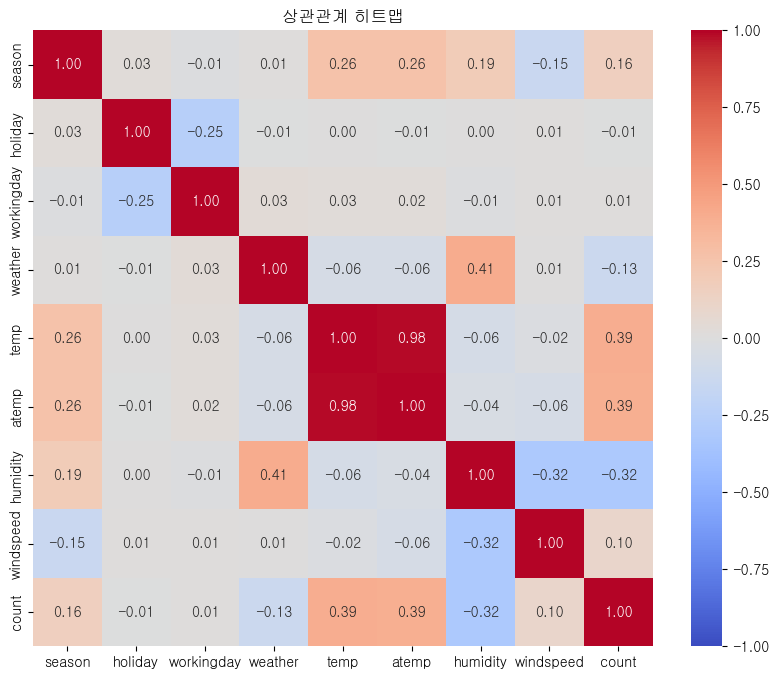

In [126]:
# 상관관계 히트맵
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm',vmin=-1, vmax=1)
plt.title('상관관계 히트맵')
plt.show()

### [해석]
1. count는 temp과 0.39 의 수치로 양의상관관계를 가지고 있다.
2. count는 atemp과 0.39 의 수치로 양의상관관계를 가지고 있다.
3. count는 humidity와 -0.32로 음의 상관관계를 가지고 있다.
4. 다른 칼럼과는 직접적인 상관관계를 보이고 있지 않음을 알 수 있다.

#### 💡 datetime과 count가 상관이 있을까?

In [127]:
# datetime 쪼개기
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour
train_df['weekday'] = train_df['datetime'].dt.weekday
train_df['is_weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

-> 년, 월, 시간, 주말(평일)구분하는 파생변수 생성

In [128]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,weekday,is_weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,5,1


In [129]:
# 주말(평일)과 일하는날(안하는날) 서로 다른 날일까?
print(train_df['is_weekend'].value_counts())
print('='*30)
print(train_df['workingday'].value_counts())
print('='*30)
train_df['workingday_equals_weekday'] = (train_df['workingday'] == (1 - train_df['is_weekend'])).astype(int)
print(train_df['workingday_equals_weekday'].value_counts())

is_weekend
0    7723
1    3163
Name: count, dtype: int64
workingday
1    7412
0    3474
Name: count, dtype: int64
workingday_equals_weekday
1    10575
0      311
Name: count, dtype: int64


### [해석]
- 311건이 주말(평일)이라고 해서 일안하는 날 이라고 보지 않기 때문에 다른 칼럼이라고 보고 삭제하지 않겠다.

#### 💡 년도, 월, 시간, 계절 등의 자전거 대여 갯수 간의 관계 시각화

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_47416\1450281529.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=train_df, x='year', y='count', palette='Set3')


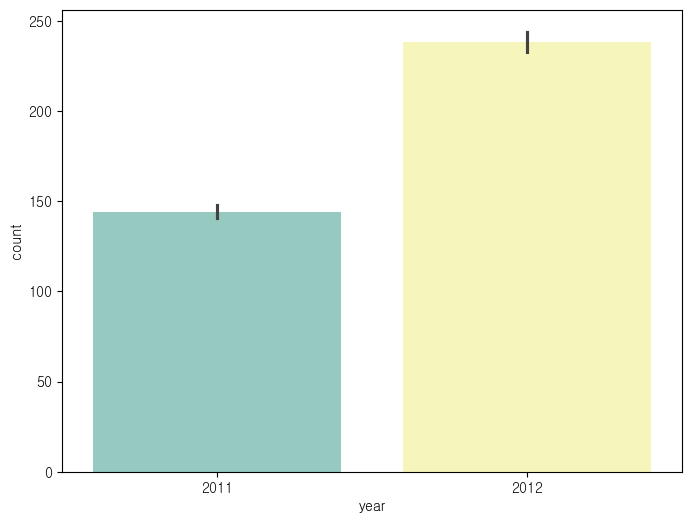

In [130]:
# 년도와 자전거 대여 갯수
import seaborn as sns
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=train_df, x='year', y='count', palette='Set3')

### [해석]
2011년도 보다 2012년도에 자전거 대여 갯수가 확연히 더 많다

-> 2011년도와 2012년도의 평균수를 가지고 측정, 최종합계도 2012년도가 확연히 큼.

추측: 년도가 지날수록 자전거를 타는 사람 수가 늘어날 수도 있다고 생각. 

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_47416\1346143931.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(train_df, x='month', y= 'count',palette="Set3")


<Axes: xlabel='month', ylabel='count'>

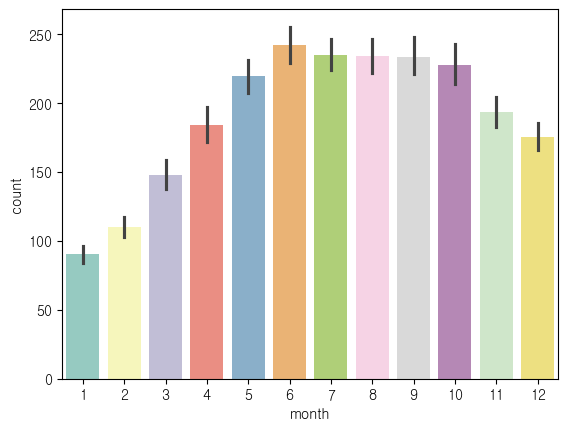

In [131]:
# 월과 자전거 대여 갯수
sns.barplot(train_df, x='month', y= 'count',palette="Set3")

### [해석]

자전거 대여 갯수는 6월~ 9월(여름철)에 수요량이 늘어나고 11월~3월(겨울철)에는 수요가 감소하는 추세이다.

<Axes: xlabel='hour', ylabel='count'>

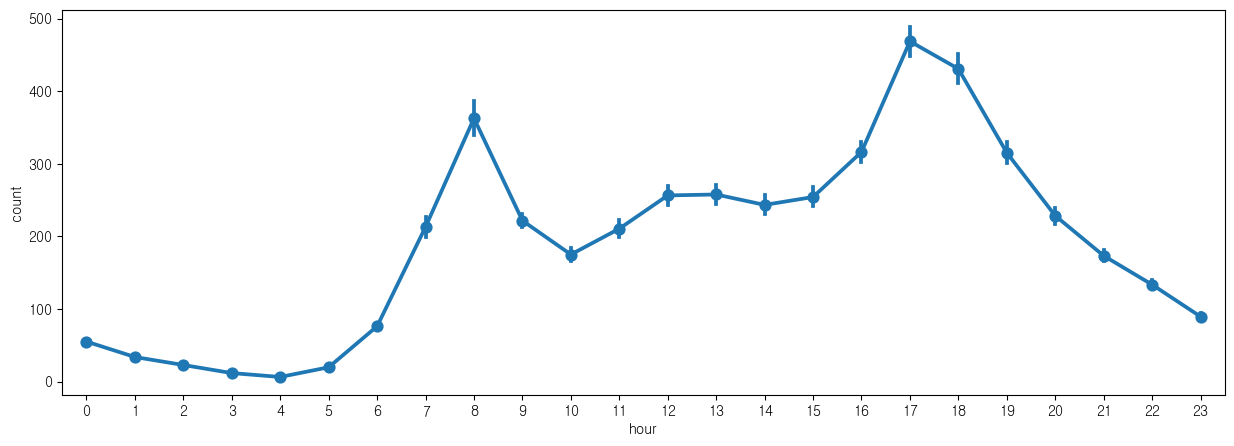

In [132]:
# 시간대 별로 자전거 대여 갯수
plt.figure(figsize=(15,5))
sns.pointplot(x = 'hour', y= 'count',data = train_df)

### [해석]
오전 7시~ 8시까지가 자전거의 수요가 급증, 17시~ 19시까지 자전거의 수요가 급증

추측: 출근시간, 퇴근시간에 수요가 급증하는 걸봐서 출퇴근을 자전거로 하는 인원이 많을 가능성이 있다.

     month  hour       count
0        1     0   23.027027
1        1     1   16.513514
2        1     2   13.000000
3        1     3    9.538462
4        1     4    3.235294
..     ...   ...         ...
283     12    19  264.710526
284     12    20  187.131579
285     12    21  146.473684
286     12    22  108.052632
287     12    23   76.868421

[288 rows x 3 columns]


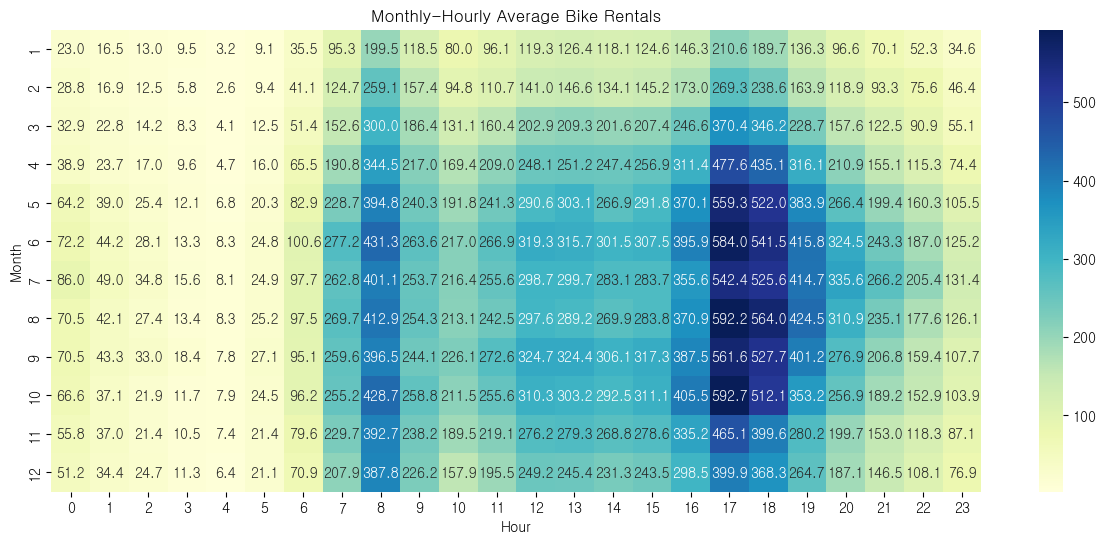

In [133]:
# 전체적인 시각화
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['hour'] = train_df['datetime'].dt.hour

result = train_df.groupby(['month', 'hour'])['count'].mean().reset_index()
print(result)

pivot = train_df.pivot_table(index='month',
                       columns='hour',
                       values='count',
                       aggfunc='mean')
pivot

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Monthly-Hourly Average Bike Rentals')
plt.xlabel('Hour')
plt.ylabel('Month')
plt.show()

#### 💡출근/퇴근때문에 자전거의 수요가 급증하는게 맞을까?

In [134]:
from matplotlib import rcParams  # 폰트지정
rcParams['font.family'] = 'Gulim'
rcParams['axes.unicode_minus'] = False

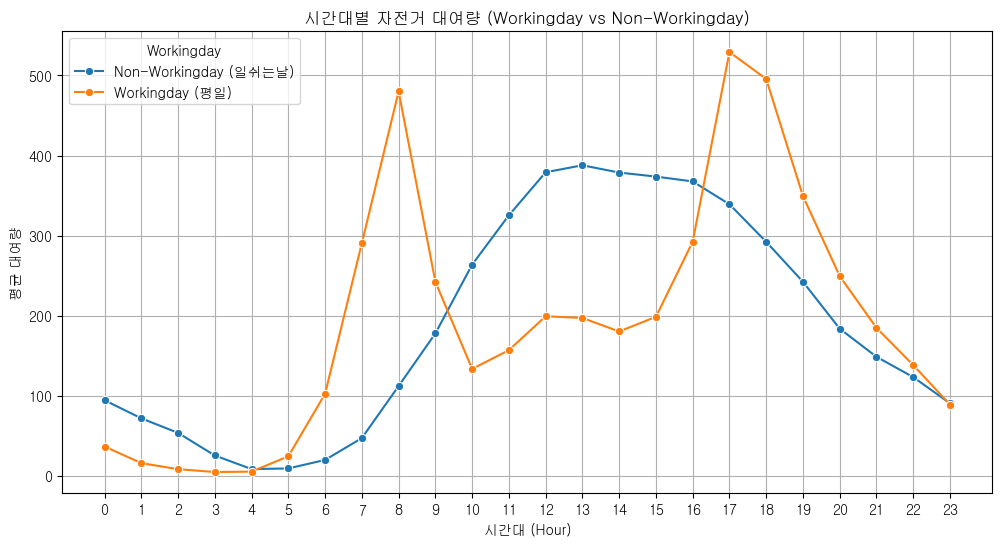

In [135]:
# workingday 칼럼 분석
plt.figure(figsize=(12, 6))
workingday_grouped = train_df.groupby(['workingday', 'hour'])['count'].mean().reset_index()

# 그래프 그리기
sns.lineplot(
    data=workingday_grouped,
    x='hour',
    y='count',
    hue='workingday',
    marker='o'
)

# 범례에 맞게 라벨 바꿔주기
plt.title('시간대별 자전거 대여량 (Workingday vs Non-Workingday)')
plt.xlabel('시간대 (Hour)')
plt.ylabel('평균 대여량')
plt.xticks(range(0, 24))

# 직접 이름 지정
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Non-Workingday (일쉬는날)', 'Workingday (평일)']
plt.legend(handles=handles, labels=new_labels, title='Workingday')

plt.grid(True)
plt.show()


### [해석]
시간대 별 자전거 대여 갯수 그래프와 평일(일하는날)의 그래프 양상이 비슷한 걸 봐서는 평일(일하는날)의 자전거 대여 갯수가 큰 영향을 주고 있다.

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_47416\3512458405.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(train_df, x = 'season', y= 'count',palette='Set3')


<Axes: xlabel='season', ylabel='count'>

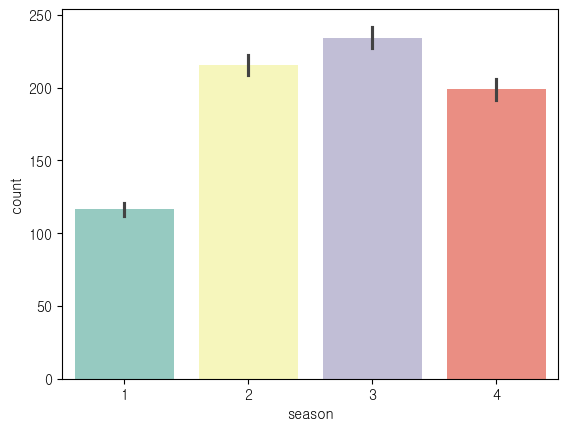

In [136]:
# 계절과 자전거 대여 갯수
sns.barplot(train_df, x = 'season', y= 'count',palette='Set3')

### [해석]
계절이 2~3(여름~가을) 일 경우 자전거 대여 수요가 크고, 1~4(겨울~봄)은 자전거에 대한 수요가 작다.

## 데이터전처리

In [137]:
# 필요없는 컬럼 삭제
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day',
       'hour', 'weekday', 'is_weekend', 'workingday_equals_weekday'],
      dtype='object')

In [138]:
train = train_df.drop(columns=['datetime','atemp','weekday'
                       ,'workingday_equals_weekday'])

In [139]:
# windspeed 구간화 라벨링
train['windspeed'].describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

In [140]:
# 사분위수 기준으로 구간나누기
q1 = 7.00
q2 = 12.00
q3 = 16.00

# 구간 경계
bins = [train_df['windspeed'].min() - 1, q1, q2, q3, train_df['windspeed'].max() + 1]

# 숫자 라벨 지정
labels = [0, 1, 2, 3]

# 범주화
train['windspeed_category'] = pd.cut(train_df['windspeed'], bins=bins, labels=labels)

다른 모든 수치형을 구간화를 진행했지만 상관관계가 떨어져서 다른 것은 구간화시키지 않았음.

windspeed의 칼럼만 0.01수치 정도 올랐다 (거의 안올름..)

In [141]:
# 시간대 구간
def time_slot(hour):
    if 6 <= hour <= 9:
        return 'morning_peak'
    elif 10 <= hour <= 16:
        return 'daytime'
    elif 17 <= hour <= 20:
        return 'evening_peak'
    else:
        return 'night'

train['time_slot'] = train_df['hour'].apply(time_slot)

count는 시간대에 대한 영향을 많이 받기 때문에 시간대 구간을 나누었다.

## 데이터분할

In [142]:
from sklearn.preprocessing import LabelEncoder

scaler = LabelEncoder()
train['time_slot'] = scaler.fit_transform(train['time_slot'])

X = train.drop(columns=['humidity','count'])
y = train_df['count'] 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [143]:
X

,season,holiday,workingday,weather,temp,windspeed,year,month,day,hour,is_weekend,windspeed_category,time_slot
0,1,0,0,1,9.84,0.0000,2011,1,1,0,1,0,3
1,1,0,0,1,9.02,0.0000,2011,1,1,1,1,0,3
2,1,0,0,1,9.02,0.0000,2011,1,1,2,1,0,3
3,1,0,0,1,9.84,0.0000,2011,1,1,3,1,0,3
4,1,0,0,1,9.84,0.0000,2011,1,1,4,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,26.0027,2012,12,19,19,0,3,1
10882,4,0,1,1,14.76,15.0013,2012,12,19,20,0,2,1
10883,4,0,1,1,13.94,15.0013,2012,12,19,21,0,2,3
10884,4,0,1,1,13.94,6.0032,2012,12,19,22,0,0,3


## 모델 생성 및 모델 성능 평가

In [155]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=99)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(np.sqrt(mse),r2)

46.513225380234644 0.9335138134056163


### 결과: RMSE는 46 r2:0.93의 설명력을 가진다.